In [11]:
import pandas as pd
import json
from tqdm import tqdm
import csv
import numpy as np
import random
from tqdm.notebook import tqdm
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import collections

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuguanwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
vocab_size = 5000
embedding_dim = 64
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [14]:
# df_data_train = pd.read_pickle('HW_train.pkl')
# df_data_test = pd.read_pickle('HW_test.pkl')

df_data_train = pd.read_pickle('HW_train.pkl')
df_data_test = pd.read_pickle('HW_test.pkl')

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def preprocess(message):
    # Lowercase the twit message
    text = message.lower()
    # Remove Punctuation
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)

    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter or apostrophe with a space (will reomve emoji)
    # text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )


    # stem may have problems like 'y' replaced by i: this->thi, pretty->pretti (u can comment out this part)
    porter = PorterStemmer()
    words = text.split() 
    text = " ".join([porter.stem(word) for word in words])
    
    #remove 1h!
    text = text.replace('lh','')
    
    return text
        

In [17]:
# you can use sampling method to reduce the size of training dataset before train
# df_data_train.sample(frac=0.5,random_state=1)

train_messages = df_data_train['text'].to_list()
df_data_train['new_text'] = [preprocess(message) for message in tqdm(train_messages)]

test_messages = df_data_test['text'].to_list()
df_data_test['new_text'] = [preprocess(message) for message in tqdm(test_messages)]

  0%|          | 0/1455563 [00:00<?, ?it/s]

  0%|          | 0/411972 [00:00<?, ?it/s]

In [18]:
# df_data_train = df_data_train[:50000]

In [19]:
def clean_stopword(article):
    for word in STOPWORDS:
        token = ' ' + word + ' '
        article = article.replace(token, ' ')
        article = article.replace(' ', ' ')
    return article

In [20]:
df_data_train['new_text'] = df_data_train['new_text'].apply(lambda x : clean_stopword(x))
df_data_test['new_text'] = df_data_test['new_text'].apply(lambda x:clean_stopword(x))

## EDA

Text(0.5, 1.0, 'Label Counts')

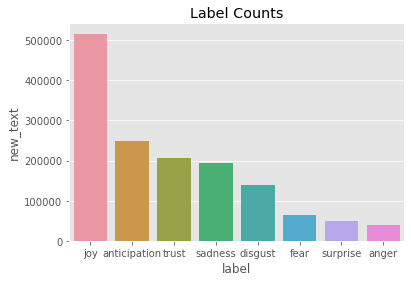

In [21]:
label = df_data_train.groupby('label').count()['new_text'].reset_index().sort_values(by='new_text',ascending=False)
sns.barplot(x='label',y='new_text',data=label)
plt.title('Label Counts')

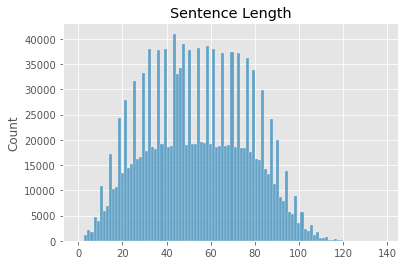

In [22]:
#plot hist of sentence length (each letter)
sns.histplot([len(s) for s in df_data_train.new_text.to_list()], bins=100)
plt.title('Sentence Length')
plt.show()

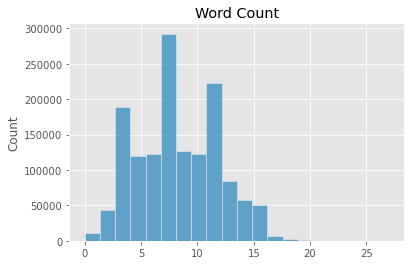

In [23]:
#plot hist of sentence word count
word = []
for s in df_data_train.new_text.to_list():
  word.append(len(s.split()))
sns.histplot(word,bins=20)
plt.title('Word Count')
plt.show()

Text(0, 0.5, 'sadness')

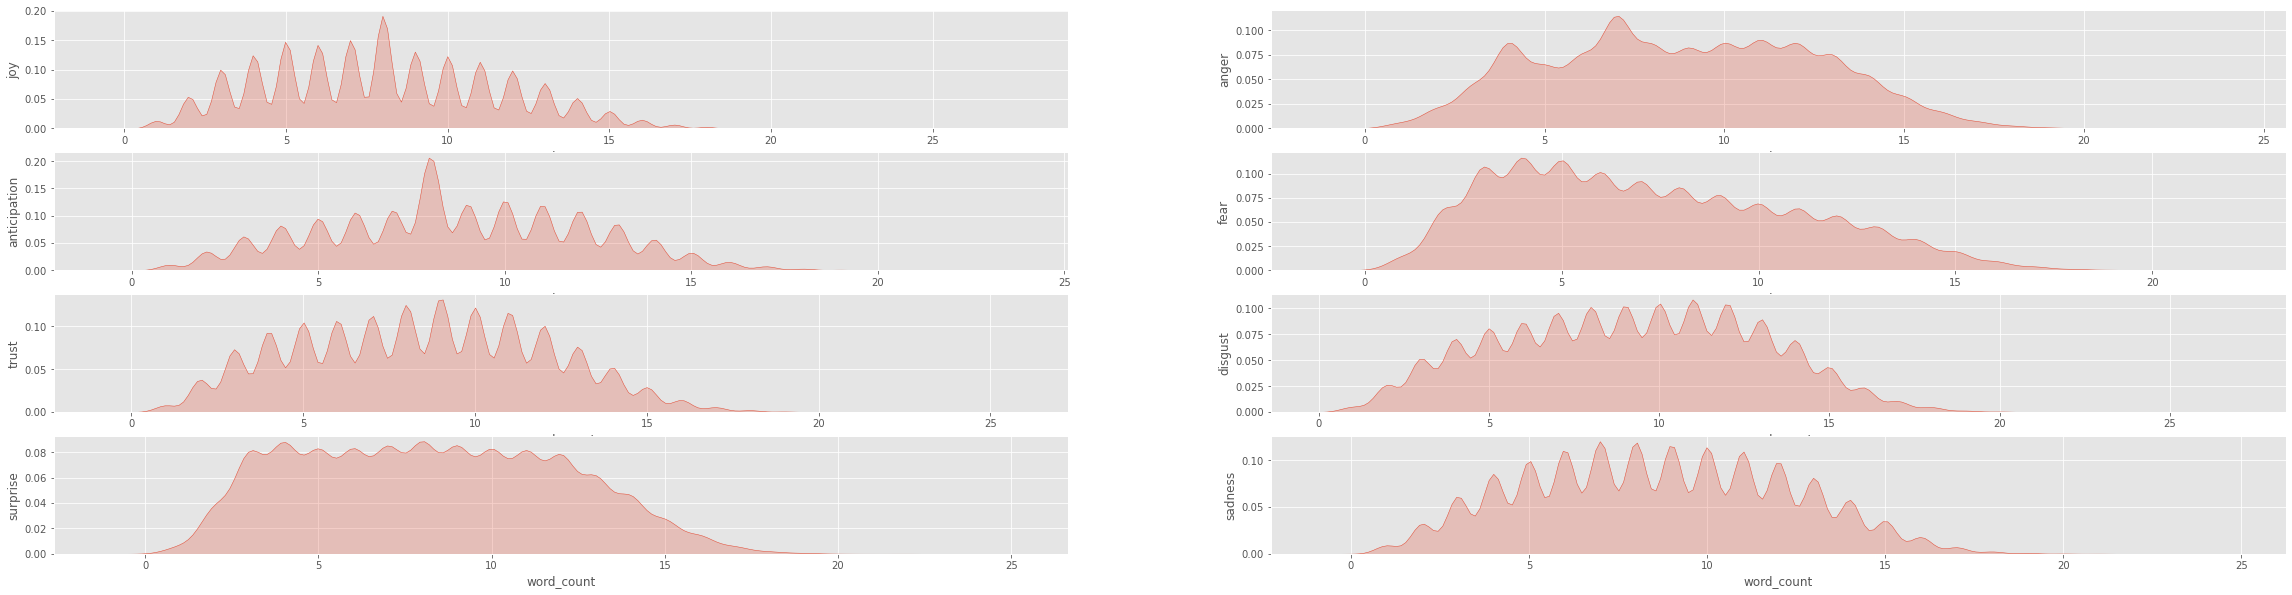

In [24]:
df_data_train['word_count'] = word
fig, axes = plt.subplots(4,2,figsize=(40,10))
sns.kdeplot(df_data_train[df_data_train['label']=='joy']['word_count'],shade=True,ax=axes[0,0])
axes[0,0].set_ylabel(ylabel='joy',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='anger']['word_count'],shade=True,ax=axes[0,1])
axes[0,1].set_ylabel(ylabel='anger',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='anticipation']['word_count'],shade=True,ax=axes[1,0])
axes[1,0].set_ylabel(ylabel='anticipation',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='fear']['word_count'],shade=True,ax=axes[1,1])
axes[1,1].set_ylabel(ylabel='fear',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='trust']['word_count'],shade=True,ax=axes[2,0])
axes[2,0].set_ylabel(ylabel='trust',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='disgust']['word_count'],shade=True,ax=axes[2,1])
axes[2,1].set_ylabel(ylabel='disgust',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='surprise']['word_count'],shade=True,ax=axes[3,0])
axes[3,0].set_ylabel(ylabel='surprise',fontsize=12)
sns.kdeplot(df_data_train[df_data_train['label']=='sadness']['word_count'],shade=True,ax=axes[3,1])
axes[3,1].set_ylabel(ylabel='sadness',fontsize=12)

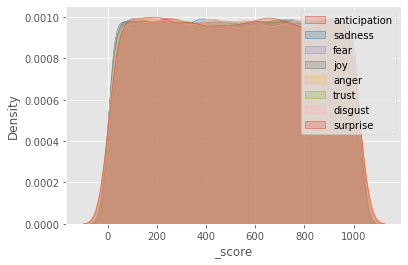

In [25]:
#plot score across different label
for i in df_data_train['label'].unique():
  sns.kdeplot(df_data_train[df_data_train['label']==i]['_score'], shade=True)
  plt.legend(labels=list(df_data_train['label'].unique()))


In [26]:
for i in df_data_train['label'].unique():
  print(i)
  print(df_data_train[df_data_train['label']==i]['_score'].describe())
  print("")

anticipation
count    248935.000000
mean        511.650254
std         295.267569
min           1.000000
25%         256.000000
50%         511.000000
75%         767.000000
max        1024.000000
Name: _score, dtype: float64

sadness
count    193437.000000
mean        511.608989
std         295.639968
min           1.000000
25%         256.000000
50%         510.000000
75%         768.000000
max        1024.000000
Name: _score, dtype: float64

fear
count    63999.000000
mean       512.792622
std        295.902792
min          1.000000
25%        255.000000
50%        514.000000
75%        769.000000
max       1024.000000
Name: _score, dtype: float64

joy
count    516017.000000
mean        512.856237
std         295.805142
min           1.000000
25%         256.000000
50%         513.000000
75%         769.000000
max        1024.000000
Name: _score, dtype: float64

anger
count    39867.000000
mean       512.108109
std        296.465849
min          1.000000
25%        256.000000
50%   

In [27]:
df_data_train.reset_index(inplace=True)

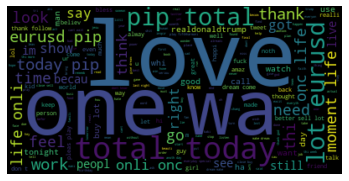

In [28]:
#word cloud
all_text = ''
for i in range(len(df_data_train)):
  all_text += df_data_train['new_text'][i]


wordcloud = WordCloud().generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


/Users/wuguanwei/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


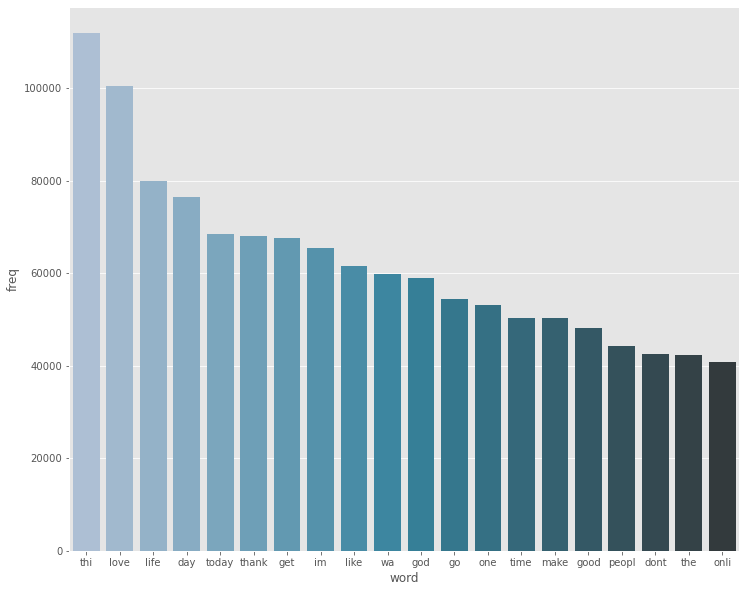

In [29]:
#word frequenct
cv = CountVectorizer()
bow = cv.fit_transform(df_data_train['new_text'].to_list())
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show()

In [30]:
label_name = list(df_data_train['label'].unique())
label_dict = {}
for index, label in enumerate(label_name):
    label_dict[label] = index

In [31]:
label_dict

{'anticipation': 0,
 'sadness': 1,
 'fear': 2,
 'joy': 3,
 'anger': 4,
 'trust': 5,
 'disgust': 6,
 'surprise': 7}

In [32]:
df_data_train['num_label'] = df_data_train.label.replace(label_dict)

In [33]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_data_train['new_text'])
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'thi': 1,
 'love': 2,
 'life': 3,
 'day': 4,
 'get': 5,
 'today': 6,
 'thank': 7,
 'im': 8,
 'like': 9,
 'wa': 10}

In [34]:
'😈' in word_index

False

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_data_train['new_text'], df_data_train['num_label'], test_size=0.2, random_state=42)

In [36]:
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[10])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

[43, 138, 1331, 267, 35, 1200, 222, 3980]


In [37]:
validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [38]:
test_sequence = tokenizer.texts_to_sequences(df_data_test['new_text'])
test_padded = pad_sequences(test_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [39]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

2021-12-20 02:22:09.150795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-20 02:22:09.150959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 394,824
Trainable params: 394,824
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_val), verbose=2)

Epoch 1/10


2021-12-20 02:22:09.495802: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-20 02:22:10.225512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 02:22:10.600688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 02:22:10.625511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 02:22:11.563812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 02:22:11.580246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 02:54:13.893816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

36390/36390 - 2124s - loss: 1.5063 - accuracy: 0.4495 - val_loss: 1.4511 - val_accuracy: 0.4717 - 2124s/epoch - 58ms/step
Epoch 2/10
36390/36390 - 1972s - loss: 1.4347 - accuracy: 0.4781 - val_loss: 1.4325 - val_accuracy: 0.4792 - 1972s/epoch - 54ms/step
Epoch 3/10
36390/36390 - 1952s - loss: 1.4217 - accuracy: 0.4833 - val_loss: 1.4291 - val_accuracy: 0.4802 - 1952s/epoch - 54ms/step
Epoch 4/10
36390/36390 - 1935s - loss: 1.4171 - accuracy: 0.4851 - val_loss: 1.4242 - val_accuracy: 0.4827 - 1935s/epoch - 53ms/step
Epoch 5/10
36390/36390 - 1942s - loss: 1.4141 - accuracy: 0.4869 - val_loss: 1.4235 - val_accuracy: 0.4845 - 1942s/epoch - 53ms/step
Epoch 6/10
36390/36390 - 1943s - loss: 1.4135 - accuracy: 0.4871 - val_loss: 1.4229 - val_accuracy: 0.4843 - 1943s/epoch - 53ms/step
Epoch 7/10
36390/36390 - 1622s - loss: 1.4113 - accuracy: 0.4880 - val_loss: 1.4218 - val_accuracy: 0.4833 - 1622s/epoch - 45ms/step
Epoch 8/10
36390/36390 - 1331s - loss: 1.4117 - accuracy: 0.4873 - val_loss: 1.4

In [41]:
# model.save('/content/drive/MyDrive/my_model')

In [42]:
predictions = model.predict(test_padded)

2021-12-20 07:14:02.721726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 07:14:02.802294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-20 07:14:02.809780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [43]:
predictions = np.argmax(predictions,axis=1)

In [44]:
predictions_label = []
for x in predictions:
    for key,value in label_dict.items():
        if x == value:
            predictions_label.append(key)
            break
        

In [45]:
df_data_test['label'] = predictions_label

In [46]:
df_data_test

,_score,hashTag,tweet_id,text,new_text,label
2,232,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",confid obedi write know even ask philemon bibl...,anticipation
4,989,[],0x2de201,"""Trust is not the same as faith. A friend is s...",trust faith friend someon trust put faith anyo...,anticipation
9,66,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,when enough satisfi goal realli money materi m...,joy
30,104,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",god woke chase day godsplan godswork,joy
33,310,[],0x26289a,"In these tough times, who do YOU turn to as yo...",in tough time turn symbol hope,trust
...,...,...,...,...,...,...
1867525,602,[],0x2913b4,"""For this is the message that ye heard from th...",for thi messag ye heard begin love one anoth j...,joy
1867529,598,[],0x2a980e,"""There is a lad here, which hath five barley l...",there lad hath five barley loav two small fish...,anticipation
1867530,827,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,when buy last ticket remain show sell mixedfee...,anticipation
1867531,368,[],0x29d0cb,I swear all this hard work gone pay off one da...,swear thi hard work gone pay one day😈💰💸,sadness


In [47]:
submission = df_data_test.drop(['_score','hashTag','text','new_text'],axis = 1)
submission.columns = ['id','emotion']

In [48]:
submission.to_csv('submission_hao.csv',index=False)